# **Problem** **Statement**: 
**OList**, an e-commerce company, is facing losses and wants to manage inventory effectively to reduce costs. The goal is to identify top revenue-generating products and analyze customer purchase behavior using market basket analysis. This analysis will help identify products that are more likely to be purchased individually or in combination with others. The company aims to reduce the number of items in specific categories without significantly impacting business.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Dataset

In [3]:
orders=pd.read_excel("/content/drive/MyDrive/Capstone Project/Retail_dataset.xlsx", sheet_name='orders')
order_items=pd.read_excel("/content/drive/MyDrive/Capstone Project/Retail_dataset.xlsx", sheet_name='order_items')
customers=pd.read_excel("/content/drive/MyDrive/Capstone Project/Retail_dataset.xlsx", sheet_name='customers')
payments=pd.read_excel("/content/drive/MyDrive/Capstone Project/Retail_dataset.xlsx", sheet_name='payments')
products=pd.read_excel("/content/drive/MyDrive/Capstone Project/Retail_dataset.xlsx", sheet_name='products')

# **Data** **Cleaning**

# Orders

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


### Dataset Description:
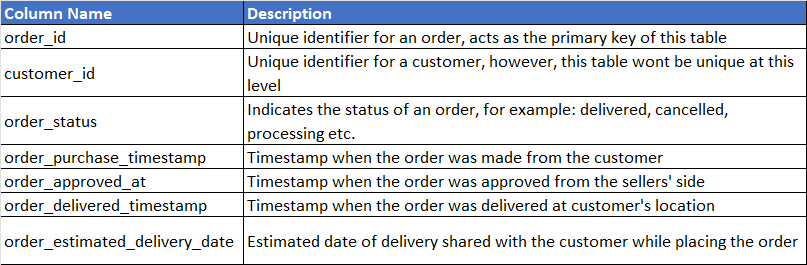

In [5]:
orders.shape

(99441, 7)

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_timestamp      96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(3)
memory usage: 5.3+ MB


In [7]:
orders.duplicated().sum()

0

There is no duplicate entries in **Orders** table

In [8]:
orders.describe(datetime_is_numeric=True)

,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
count,99441,99281,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-10-17 13:22:46,2018-11-12 00:00:00


Our data has transaction between 04-09-2016 to 17-10-2018

In [9]:
orders.describe(include=['O'])

,order_id,customer_id,order_status
count,99441,99441,99441
unique,99441,96096,8
top,e481f51cbdc54678b7cc49136f2d6af7,8d50f5eadf50201ccdcedfb9e2ac8455,delivered
freq,1,17,96478


There are 96096 unique customers in our data. Customer with ID '8d50f5eadf50201ccdcedfb9e2ac8455' appears most frequently in data (17 times)

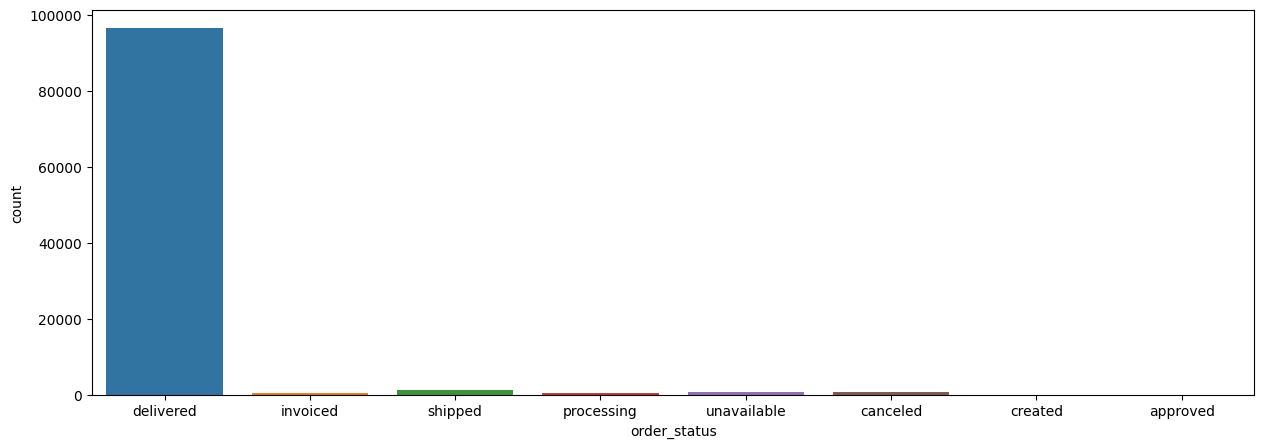

In [10]:
plt.figure(figsize=(15,5))
sns.countplot(data=orders, x=orders['order_status'])
plt.show()

## Cohort Analysis
### Create month cohort of customers and analyze active customers in each cohort:

In [11]:
orders['month_year']=orders['order_purchase_timestamp'].dt.to_period('M')
orders['month_year'].nunique()

25

In [12]:
month_cohort=orders.groupby('month_year')['customer_id'].nunique()
month_cohort

month_year
2016-09       4
2016-10     321
2016-12       1
2017-01     765
2017-02    1755
2017-03    2642
2017-04    2372
2017-05    3625
2017-06    3180
2017-07    3947
2017-08    4246
2017-09    4212
2017-10    4561
2017-11    7430
2017-12    5603
2018-01    7166
2018-02    6569
2018-03    7115
2018-04    6882
2018-05    6814
2018-06    6128
2018-07    6230
2018-08    6460
2018-09      14
2018-10       4
Freq: M, Name: customer_id, dtype: int64

Text(0.5, 1.0, 'No. of active customers in each month')

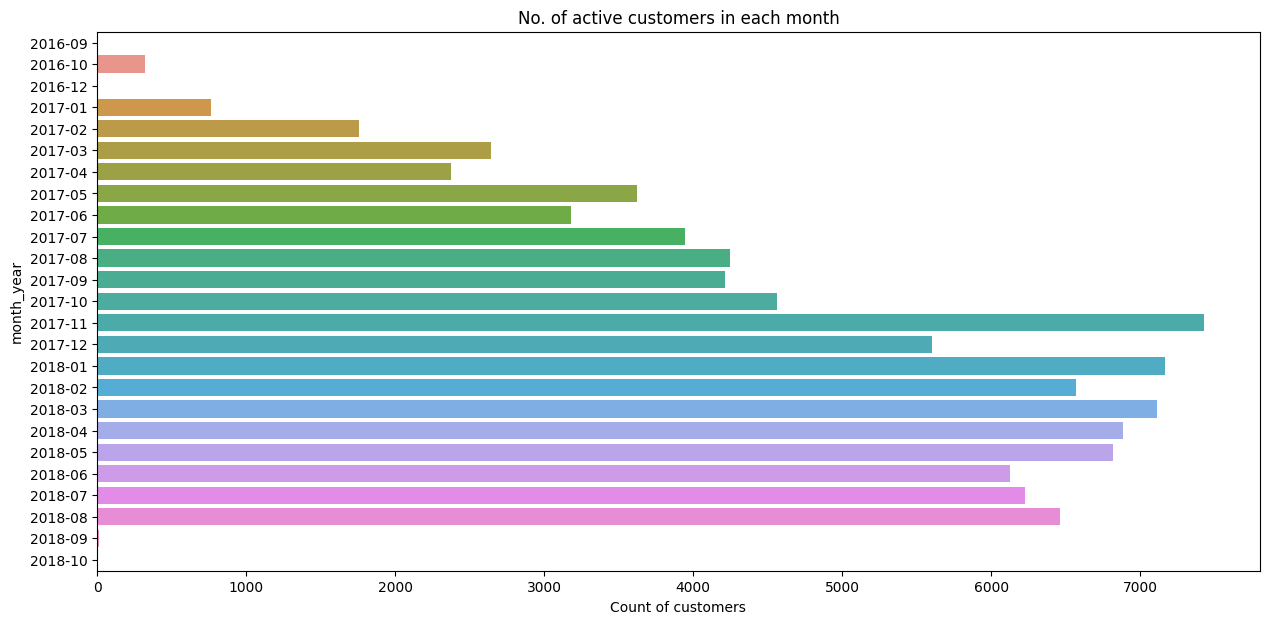

In [13]:
plt.figure(figsize=(15,7))
sns.barplot(y = month_cohort.index, x = month_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of active customers in each month")

In [14]:
orders['year']=orders['order_purchase_timestamp'].dt.to_period('Y')
orders['year'].nunique()

3

In [15]:
year_cohort=orders.groupby('year')['customer_id'].nunique()
year_cohort

year
2016      326
2017    43713
2018    52749
Freq: A-DEC, Name: customer_id, dtype: int64

Text(0.5, 1.0, 'No. of purchases in each year')

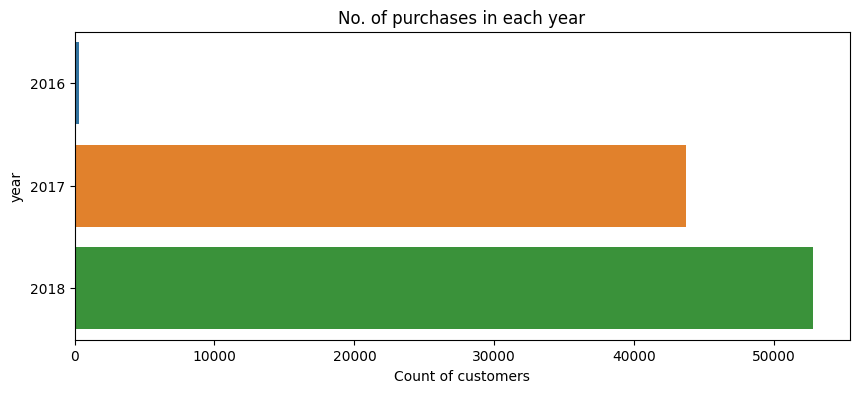

In [16]:
plt.figure(figsize=(10,4))
sns.barplot(y = year_cohort.index, x = year_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of purchases in each year")

#### Missing Values treatment

In [17]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_timestamp        2965
order_estimated_delivery_date       0
month_year                          0
year                                0
dtype: int64

### Filtering order status as 'delivered'

In [18]:
orders_delivered=orders[orders.order_status=='delivered']

In [19]:
orders_delivered.shape

(96478, 9)

In [20]:
orders_delivered.isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_timestamp         8
order_estimated_delivery_date     0
month_year                        0
year                              0
dtype: int64

Only one column 'order_approved_at' have the missing value

we are taking median of differences between order_approved_at and order_purchased and then filling the nan values with sum of order_purchased and diff


In [21]:
median_timestamp=(orders_delivered['order_purchase_timestamp']-orders_delivered['order_approved_at']).median()
orders_delivered['order_approved_at'].fillna(orders_delivered['order_purchase_timestamp']+median_timestamp, inplace=True)

we are taking median of differences between order_delivered_carrier_date and order_approved_at and then filling the nan values with sum of order_approved_at and diff


In [22]:
median_timestamp2=(orders_delivered['order_delivered_timestamp']-orders_delivered['order_approved_at']).median()
orders_delivered['order_delivered_timestamp'].fillna(orders_delivered['order_approved_at']+median_timestamp2, inplace=True)

In [23]:
orders_delivered.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
month_year                       0
year                             0
dtype: int64

# Order_items

### Dataset Description:
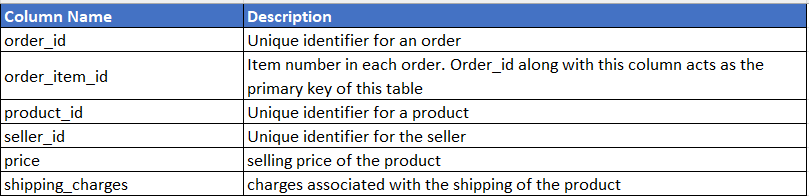

In [24]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,0812eb902a67711a1cb742b3cdaa65ae,1,489ae2aa008f021502940f251d4cce7f,e3b4998c7a498169dc7bce44e6bb6277,6735.0,194.31
1,fefacc66af859508bf1a7934eab1e97f,1,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,6729.0,193.21
2,f5136e38d1a14a4dbd87dff67da82701,1,1bdf5e6731585cf01aa8169c7028d6ad,ee27a8f15b1dded4d213a468ba4eb391,6499.0,227.66
3,a96610ab360d42a2e5335a3998b4718a,1,a6492cc69376c469ab6f61d8f44de961,59417c56835dd8e2e72f91f809cd4092,4799.0,151.34
4,199af31afc78c699f0dbf71fb178d4d4,1,c3ed642d592594bb648ff4a04cee2747,59417c56835dd8e2e72f91f809cd4092,4690.0,74.34


In [25]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          112650 non-null  object 
 1   order_item_id     112650 non-null  int64  
 2   product_id        112650 non-null  object 
 3   seller_id         112650 non-null  object 
 4   price             112650 non-null  float64
 5   shipping_charges  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


In [26]:
order_items.duplicated().sum()

0

There is no duplicate entries in **Order** items table

In [27]:
order_items.describe()

,order_item_id,price,shipping_charges
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


- **price**: Average price of each product in transactions is 120.65
- **shipping_charges**: Average shipping charge of each product in transactions is 19.99



In [28]:
order_items.isna().sum()

order_id            0
order_item_id       0
product_id          0
seller_id           0
price               0
shipping_charges    0
dtype: int64

# Customers

### Dataset Description:
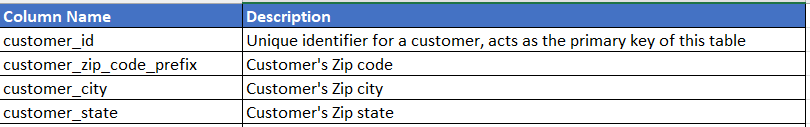

In [29]:
customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [30]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


Coverting datatype of 'customer_zip_code_prefix' to String

In [31]:
customers['customer_zip_code_prefix']=customers['customer_zip_code_prefix'].astype(str)

In [32]:
customers.duplicated().sum()

3089

Dropping duplicated entries of customers

In [33]:
customers.drop_duplicates(subset="customer_id", keep="first", inplace=True)

In [34]:
customers.shape

(96096, 4)

In [35]:
customers.isna().sum()

customer_id                 0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

# Payments

### Dataset Description:
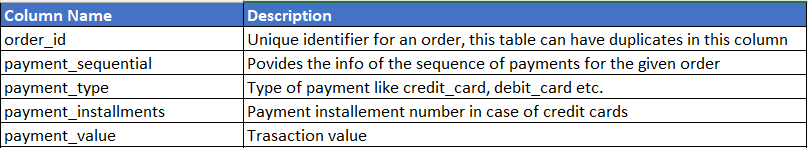

In [36]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [37]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [38]:
payments.duplicated().sum()

0

There is no duplicate entries in payments table

In [39]:
payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

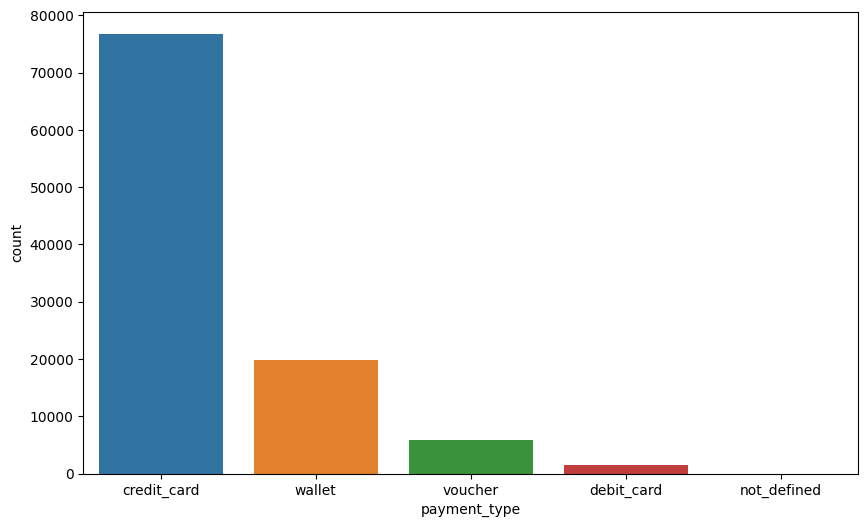

In [40]:
#Checking the most used 'payment_type' and their counts.

plt.figure(figsize=(10,6))
sns.countplot(data=payments, x=payments['payment_type'])
plt.show()

Most number of customers prefer credit card for payments

# Products

### Dataset Description:
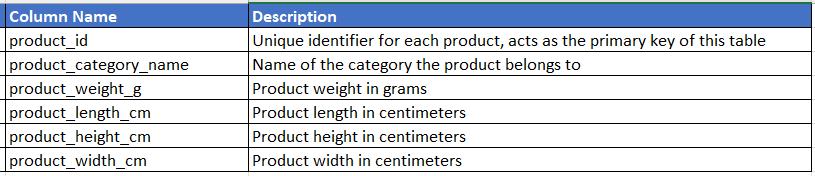

In [41]:
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


In [42]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32781 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [43]:
products.shape

(32951, 6)

In [44]:
products.duplicated().sum()

0

There is no duplicated entries in **Product** table

In [45]:
products.isna().sum()

product_id                 0
product_category_name    170
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

As we can see 5 columns in data have missing values.

- product_category_name    170
- product_weight_g           2
- product_length_cm          2
- product_height_cm          2
- product_width_cm           2


Filling the missing number of 'product_category_name' with 'Others'.

In [46]:
products['product_category_name']=products['product_category_name'].fillna('Others')

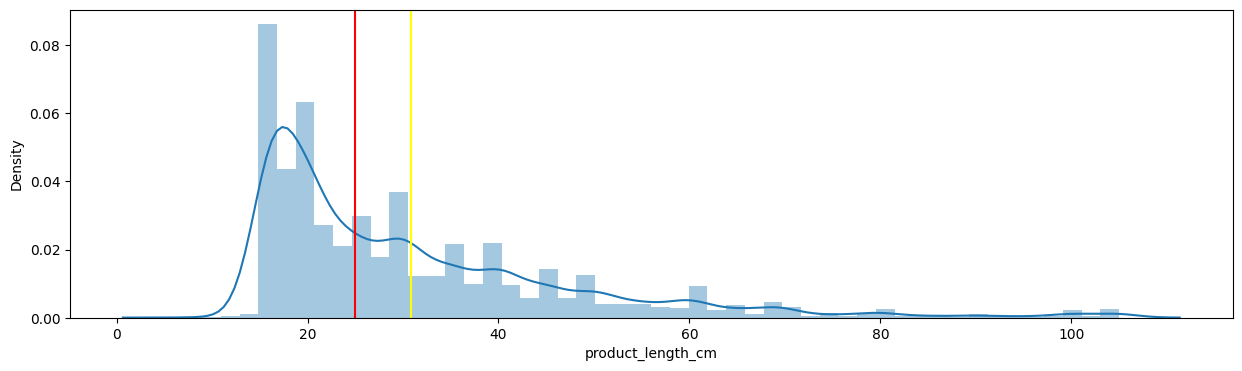

In [47]:
#Visualizing the product_length_cm for data skewness

plt.figure(figsize=(15,4))
sns.distplot(products.product_length_cm)
plt.axvline(products.product_length_cm.mean(), color="yellow")
plt.axvline(products.product_length_cm.median(), color="red")
plt.show()

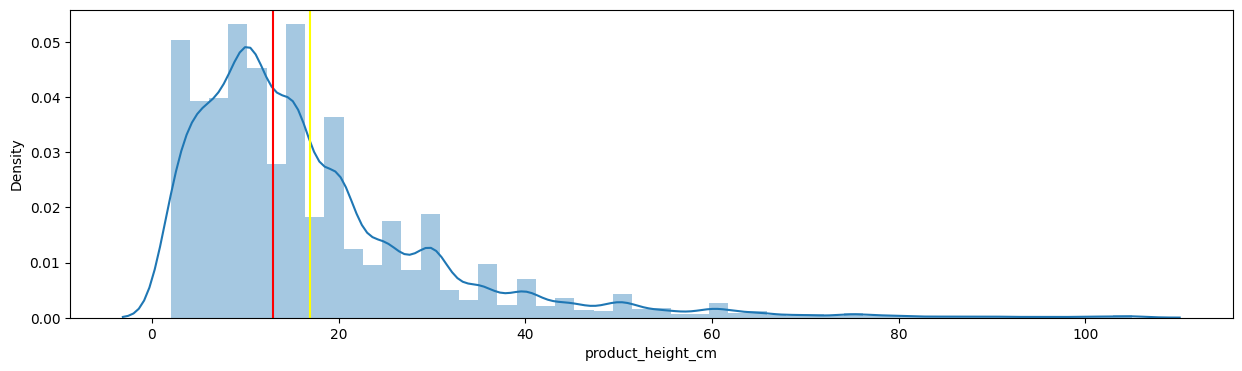

In [48]:
#Visualizing the product_height_cm for data skewness

plt.figure(figsize=(15,4))
sns.distplot(products.product_height_cm)
plt.axvline(products.product_height_cm.mean(), color="yellow")
plt.axvline(products.product_height_cm.median(), color="red")
plt.show()

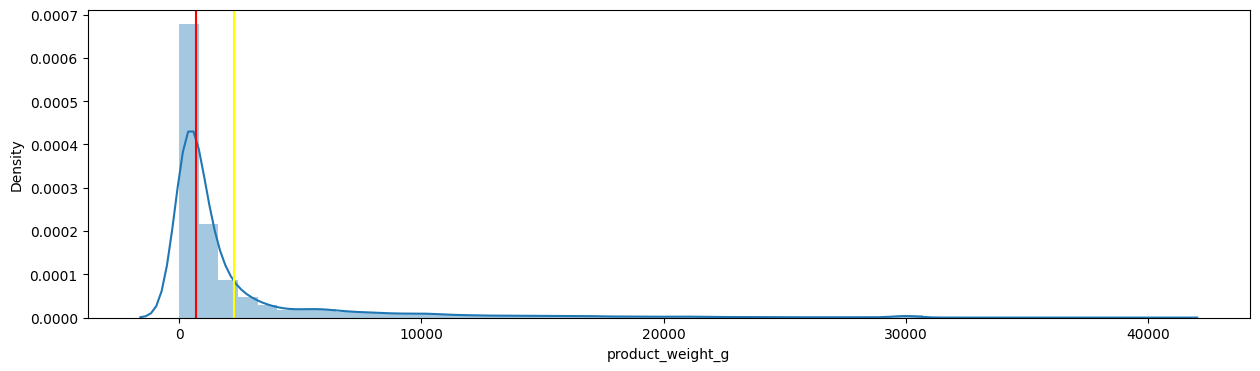

In [49]:
#Visualizing the product_weight_g for data skewness

plt.figure(figsize=(15,4))
sns.distplot(products.product_weight_g)
plt.axvline(products.product_weight_g.mean(), color="yellow")
plt.axvline(products.product_weight_g.median(), color="red")
plt.show()

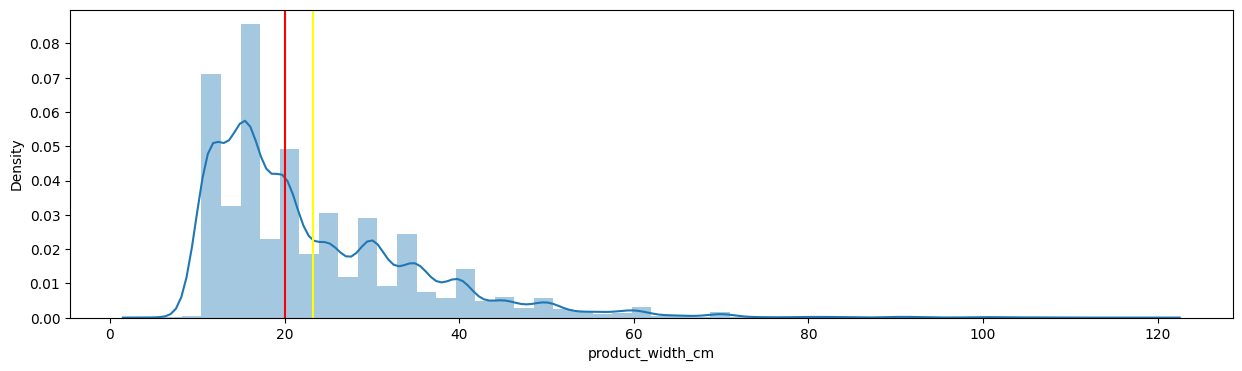

In [50]:
#Visualizing the product_width_cm for data skewness

plt.figure(figsize=(15,4))
sns.distplot(products.product_width_cm)
plt.axvline(products.product_width_cm.mean(), color="yellow")
plt.axvline(products.product_width_cm.median(), color="red")
plt.show()

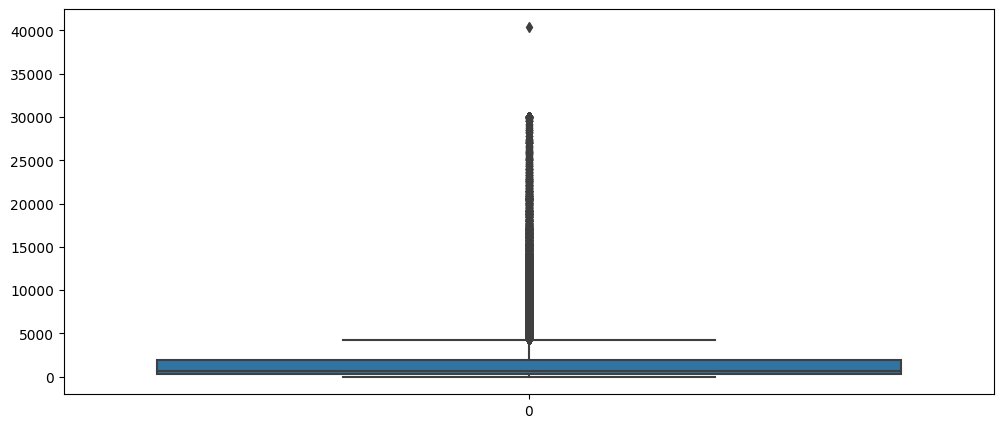

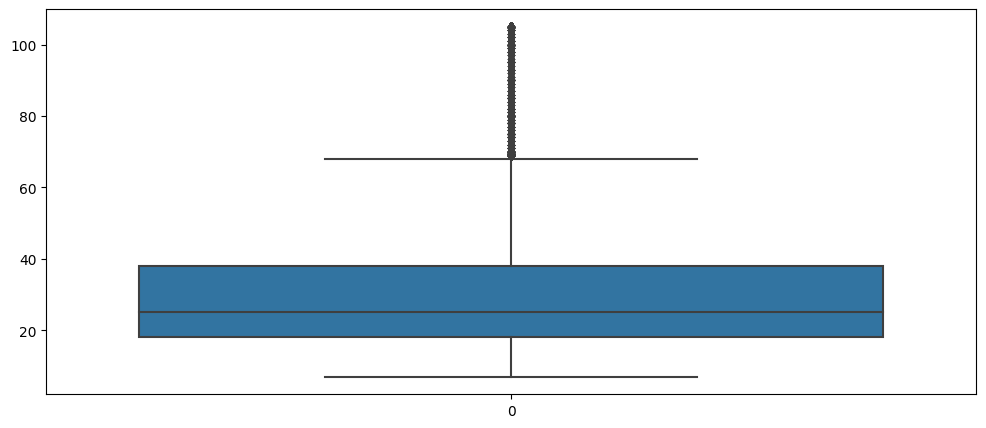

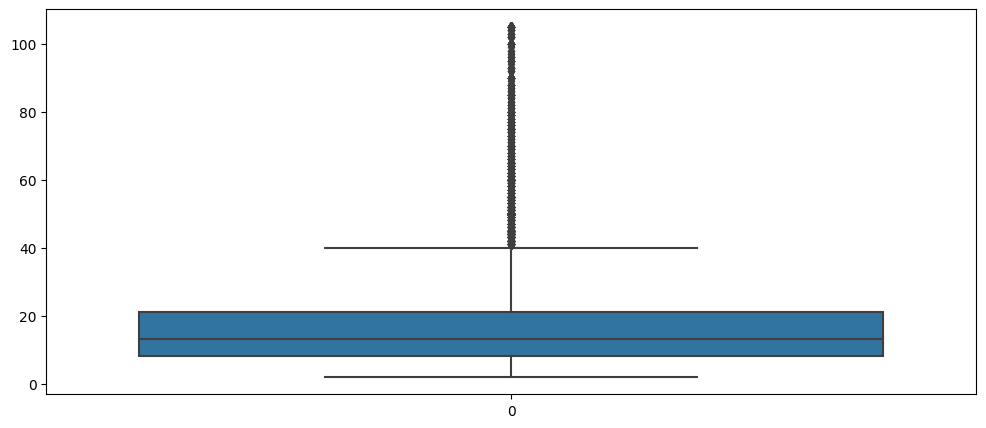

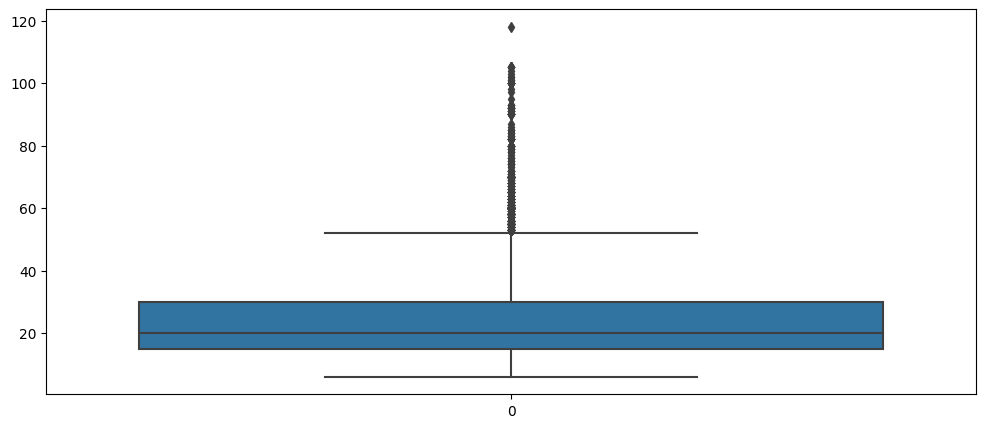

In [51]:
num_cols = products.describe().columns.to_list()
num_cols

for i in num_cols:
    plt.figure(figsize=(12,5))
    sns.boxplot(products[i])
    plt.show()
    print("="*90)

Imputing the missing values with **Median**. Since all of them having right skewed distribution.


In [52]:
products.product_height_cm.fillna(products.product_height_cm.median(),inplace=True)
products.product_width_cm.fillna(products.product_width_cm.median(),inplace=True)
products.product_length_cm.fillna(products.product_length_cm.median(),inplace=True)
products.product_weight_g.fillna(products.product_weight_g.median(),inplace=True)

In [53]:
products.isna().sum()

product_id               0
product_category_name    0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

In [54]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 5.5 MB/s eta 0:00:00


In [55]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Capstone Project/New_Retail_dataset.xlsx', engine='xlsxwriter')
orders_delivered.to_excel(writer, sheet_name='orders')
order_items.to_excel(writer, sheet_name='order_items')
customers.to_excel(writer, sheet_name='customers')
products.to_excel(writer, sheet_name='products')
payments.to_excel(writer, sheet_name='payments')
writer.save()


# **Merging** Dataset
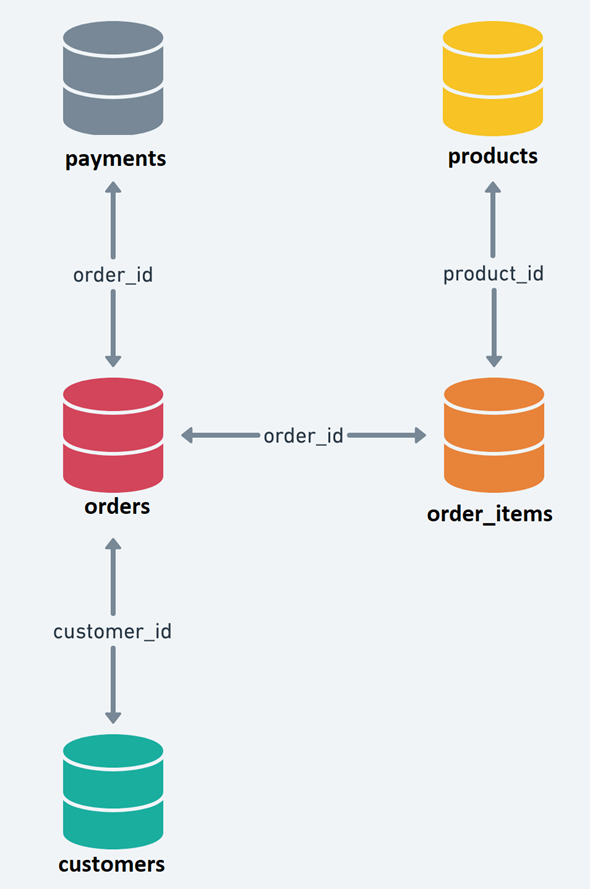

In [56]:
data=pd.merge(orders_delivered,order_items,how='inner', on='order_id')
data=pd.merge(data,products,how='inner', on='product_id')
data=pd.merge(data,payments,how='inner', on='order_id')
data=pd.merge(data,customers,how='inner', on='customer_id')

data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,month_year,year,order_item_id,...,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10,2017,1,...,19.0,8.0,13.0,1,credit_card,1,18.12,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10,2017,1,...,19.0,8.0,13.0,3,voucher,1,2.00,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10,2017,1,...,19.0,8.0,13.0,2,voucher,1,18.59,3149,sao paulo,SP
3,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-05 19:20:20,2017-09-15,2017-09,2017,1,...,19.0,14.0,12.0,1,credit_card,1,44.11,3149,sao paulo,SP
4,128e10d95713541c87cd1a2e48201934,3a51803cc0d012c3b5dc8b7528cb05f7,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,2017-08,2017,1,...,19.0,8.0,13.0,1,credit_card,3,37.77,3366,sao paulo,SP


In [57]:
data.shape

(115035, 26)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115035 entries, 0 to 115034
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115035 non-null  object        
 1   customer_id                    115035 non-null  object        
 2   order_status                   115035 non-null  object        
 3   order_purchase_timestamp       115035 non-null  datetime64[ns]
 4   order_approved_at              115035 non-null  datetime64[ns]
 5   order_delivered_timestamp      115035 non-null  datetime64[ns]
 6   order_estimated_delivery_date  115035 non-null  datetime64[ns]
 7   month_year                     115035 non-null  period[M]     
 8   year                           115035 non-null  period[A-DEC] 
 9   order_item_id                  115035 non-null  int64         
 10  product_id                     115035 non-null  object        
 11  

In [59]:
data.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
month_year                       0
year                             0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
shipping_charges                 0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

### Exporting cleaned dataset to an excel

In [60]:
from google.colab import files
data.to_csv('data.csv')
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
data.duplicated().sum()

0

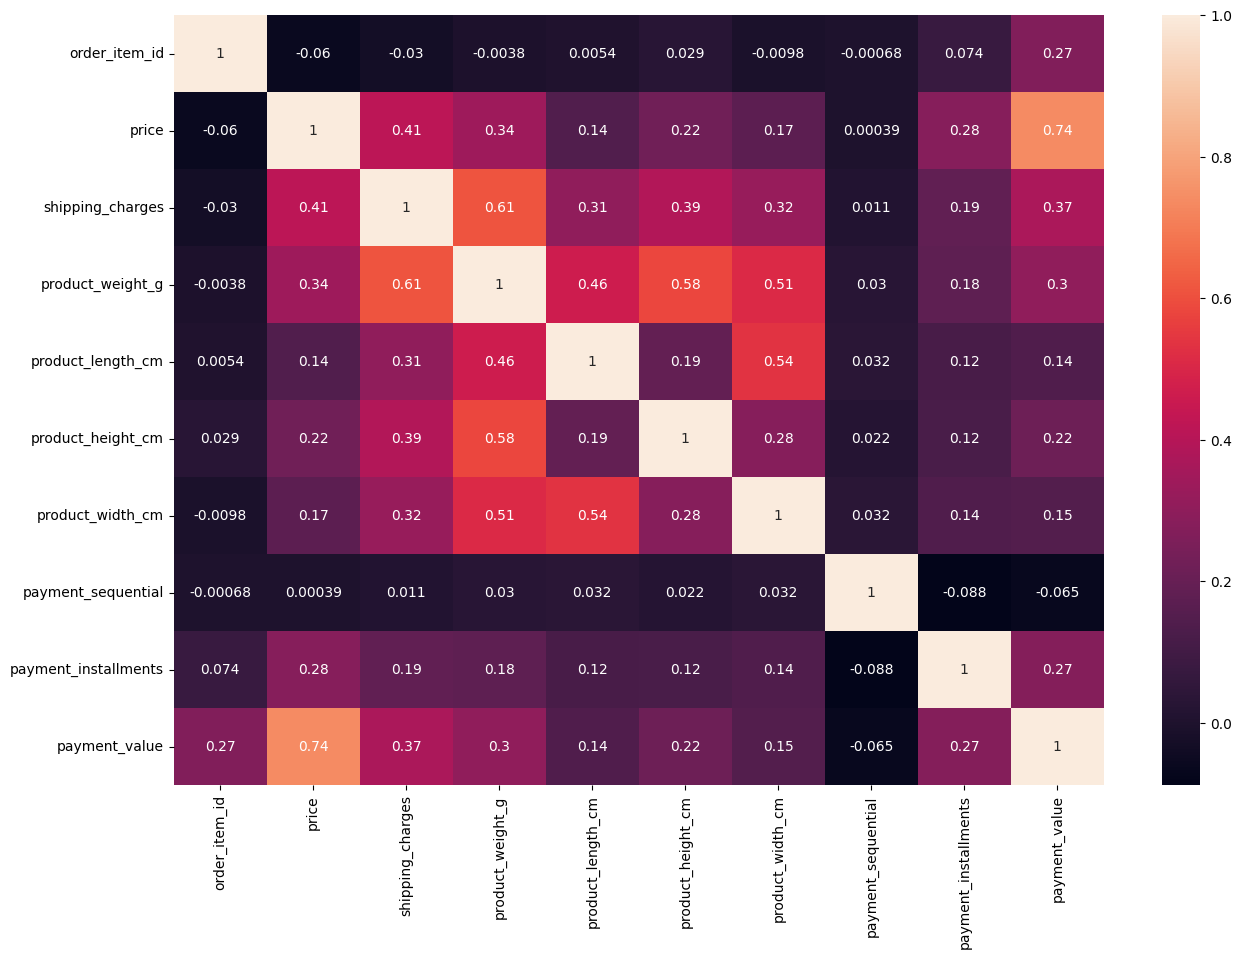

In [62]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

 # RFM Modelling
 
We need to create 3 freatures from the data:
- Recency: How recently has the customer made a transaction.
Latest date - last purchase date
- Frequency: How frequently the customer made the transaction.
- Monetary: How much does the customer spend on purchasing products.


#### Recency

In [63]:
#finding the last date on which a customer made purchase
recency=pd.DataFrame(data.groupby('product_id')['order_purchase_timestamp'].max().reset_index())


In [64]:
recency

,product_id,order_purchase_timestamp
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20 18:45:21
1,00088930e925c41fd95ebfe695fd2655,2017-12-12 19:20:28
2,0009406fd7479715e4bef61dd91f2462,2017-12-21 16:21:47
3,000b8f95fcb9e0096488278317764d19,2018-08-10 13:24:35
4,000d9be29b5207b54e86aa1b1ac54872,2018-04-03 09:24:12
...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,2017-09-03 11:38:54
32212,fff81cc3158d2725c0655ab9ba0f712c,2018-07-30 09:18:59
32213,fff9553ac224cec9d15d49f5a263411f,2017-10-06 16:44:05
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10 17:15:07


In [65]:
recency['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [66]:
# Calculating recency using maximum date of purchase made by a customer as the date to calculate the recency of purchases
recency['recent_days']=(recency['order_purchase_timestamp'].max()-recency['order_purchase_timestamp']).dt.days
recency

,product_id,order_purchase_timestamp,recent_days
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20 18:45:21,100
1,00088930e925c41fd95ebfe695fd2655,2017-12-12 19:20:28,259
2,0009406fd7479715e4bef61dd91f2462,2017-12-21 16:21:47,250
3,000b8f95fcb9e0096488278317764d19,2018-08-10 13:24:35,19
4,000d9be29b5207b54e86aa1b1ac54872,2018-04-03 09:24:12,148
...,...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,2017-09-03 11:38:54,360
32212,fff81cc3158d2725c0655ab9ba0f712c,2018-07-30 09:18:59,30
32213,fff9553ac224cec9d15d49f5a263411f,2017-10-06 16:44:05,326
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10 17:15:07,18


#### Calculating Frequency
We will count the number of unique orders made by each customer to obtain their purchase frequencies.

In [67]:
frequency=pd.DataFrame(data.groupby('product_id')['customer_id'].count().reset_index())
frequency


,product_id,customer_id
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,2
32212,fff81cc3158d2725c0655ab9ba0f712c,1
32213,fff9553ac224cec9d15d49f5a263411f,1
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,5


#### Calculating Monetary

In [68]:
monetary=pd.DataFrame(data[['product_id','payment_value']].groupby('product_id')['payment_value'].sum().reset_index())
monetary

,product_id,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,120.24
1,00088930e925c41fd95ebfe695fd2655,143.83
2,0009406fd7479715e4bef61dd91f2462,242.10
3,000b8f95fcb9e0096488278317764d19,157.00
4,000d9be29b5207b54e86aa1b1ac54872,218.27
...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,285.39
32212,fff81cc3158d2725c0655ab9ba0f712c,97.89
32213,fff9553ac224cec9d15d49f5a263411f,43.85
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,228.82


## Merging all three columns in one dataframe

In [69]:
df_rfm=pd.merge(recency,frequency,on='product_id')
df_rfm=pd.merge(df_rfm,monetary,on='product_id')
df_rfm

,product_id,order_purchase_timestamp,recent_days,customer_id,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20 18:45:21,100,1,120.24
1,00088930e925c41fd95ebfe695fd2655,2017-12-12 19:20:28,259,1,143.83
2,0009406fd7479715e4bef61dd91f2462,2017-12-21 16:21:47,250,1,242.10
3,000b8f95fcb9e0096488278317764d19,2018-08-10 13:24:35,19,2,157.00
4,000d9be29b5207b54e86aa1b1ac54872,2018-04-03 09:24:12,148,1,218.27
...,...,...,...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,2017-09-03 11:38:54,360,2,285.39
32212,fff81cc3158d2725c0655ab9ba0f712c,2018-07-30 09:18:59,30,1,97.89
32213,fff9553ac224cec9d15d49f5a263411f,2017-10-06 16:44:05,326,1,43.85
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10 17:15:07,18,5,228.82


In [70]:
#dropping unneccesary column
df_rfm.drop(['order_purchase_timestamp'],axis=1,inplace=True)
df_rfm

,product_id,recent_days,customer_id,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,100,1,120.24
1,00088930e925c41fd95ebfe695fd2655,259,1,143.83
2,0009406fd7479715e4bef61dd91f2462,250,1,242.10
3,000b8f95fcb9e0096488278317764d19,19,2,157.00
4,000d9be29b5207b54e86aa1b1ac54872,148,1,218.27
...,...,...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,360,2,285.39
32212,fff81cc3158d2725c0655ab9ba0f712c,30,1,97.89
32213,fff9553ac224cec9d15d49f5a263411f,326,1,43.85
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,18,5,228.82


In [71]:
df_rfm.columns=['product_id','Recency','Frequency','Monetary']
df_rfm.reset_index()
df_rfm.set_index("product_id",inplace=True)

In [72]:
df_rfm

,Recency,Frequency,Monetary
product_id,,,
00066f42aeeb9f3007548bb9d3f33c38,100,1,120.24
00088930e925c41fd95ebfe695fd2655,259,1,143.83
0009406fd7479715e4bef61dd91f2462,250,1,242.10
000b8f95fcb9e0096488278317764d19,19,2,157.00
000d9be29b5207b54e86aa1b1ac54872,148,1,218.27
...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,360,2,285.39
fff81cc3158d2725c0655ab9ba0f712c,30,1,97.89
fff9553ac224cec9d15d49f5a263411f,326,1,43.85


In [73]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,32216.000000,32216.000000,32216.000000
mean,205.558884,3.570741,613.861449
std,159.211091,10.971294,2163.471674
min,0.000000,1.000000,9.590000
25%,67.000000,1.000000,91.787500
50%,174.000000,1.000000,198.260000
75%,312.000000,3.000000,477.425000
max,695.000000,529.000000,109312.640000


In [74]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

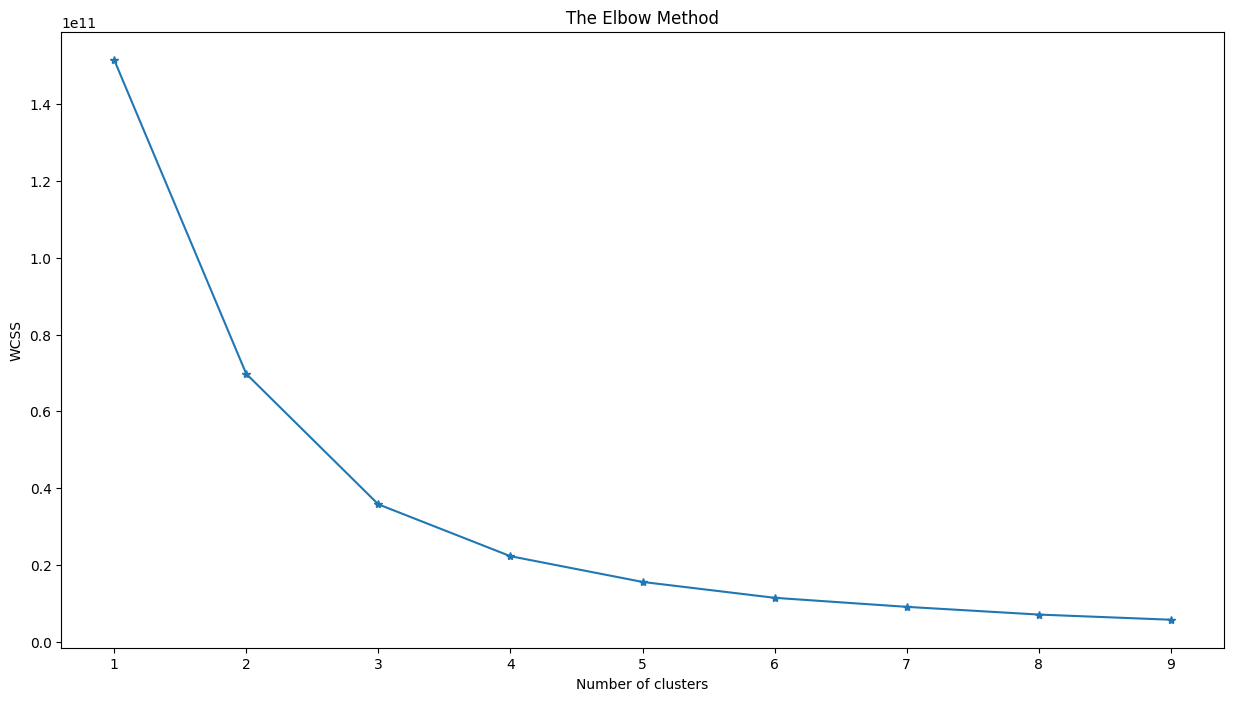

In [75]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_rfm)
    wcss.append(kmeans.inertia_)

f, ax = plt.subplots(figsize=(15, 8))  
plt.style.use('_classic_test_patch')  
plt.plot(range(1, 10), wcss, '-*')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS');

### Observation:
We can see there is a sharp turn from the 4 point. We can select values between 4 to 6 for our clusters.


In [76]:
(df_rfm[df_rfm["Frequency"]>1].shape[0]/32216)*100

47.04805065805811

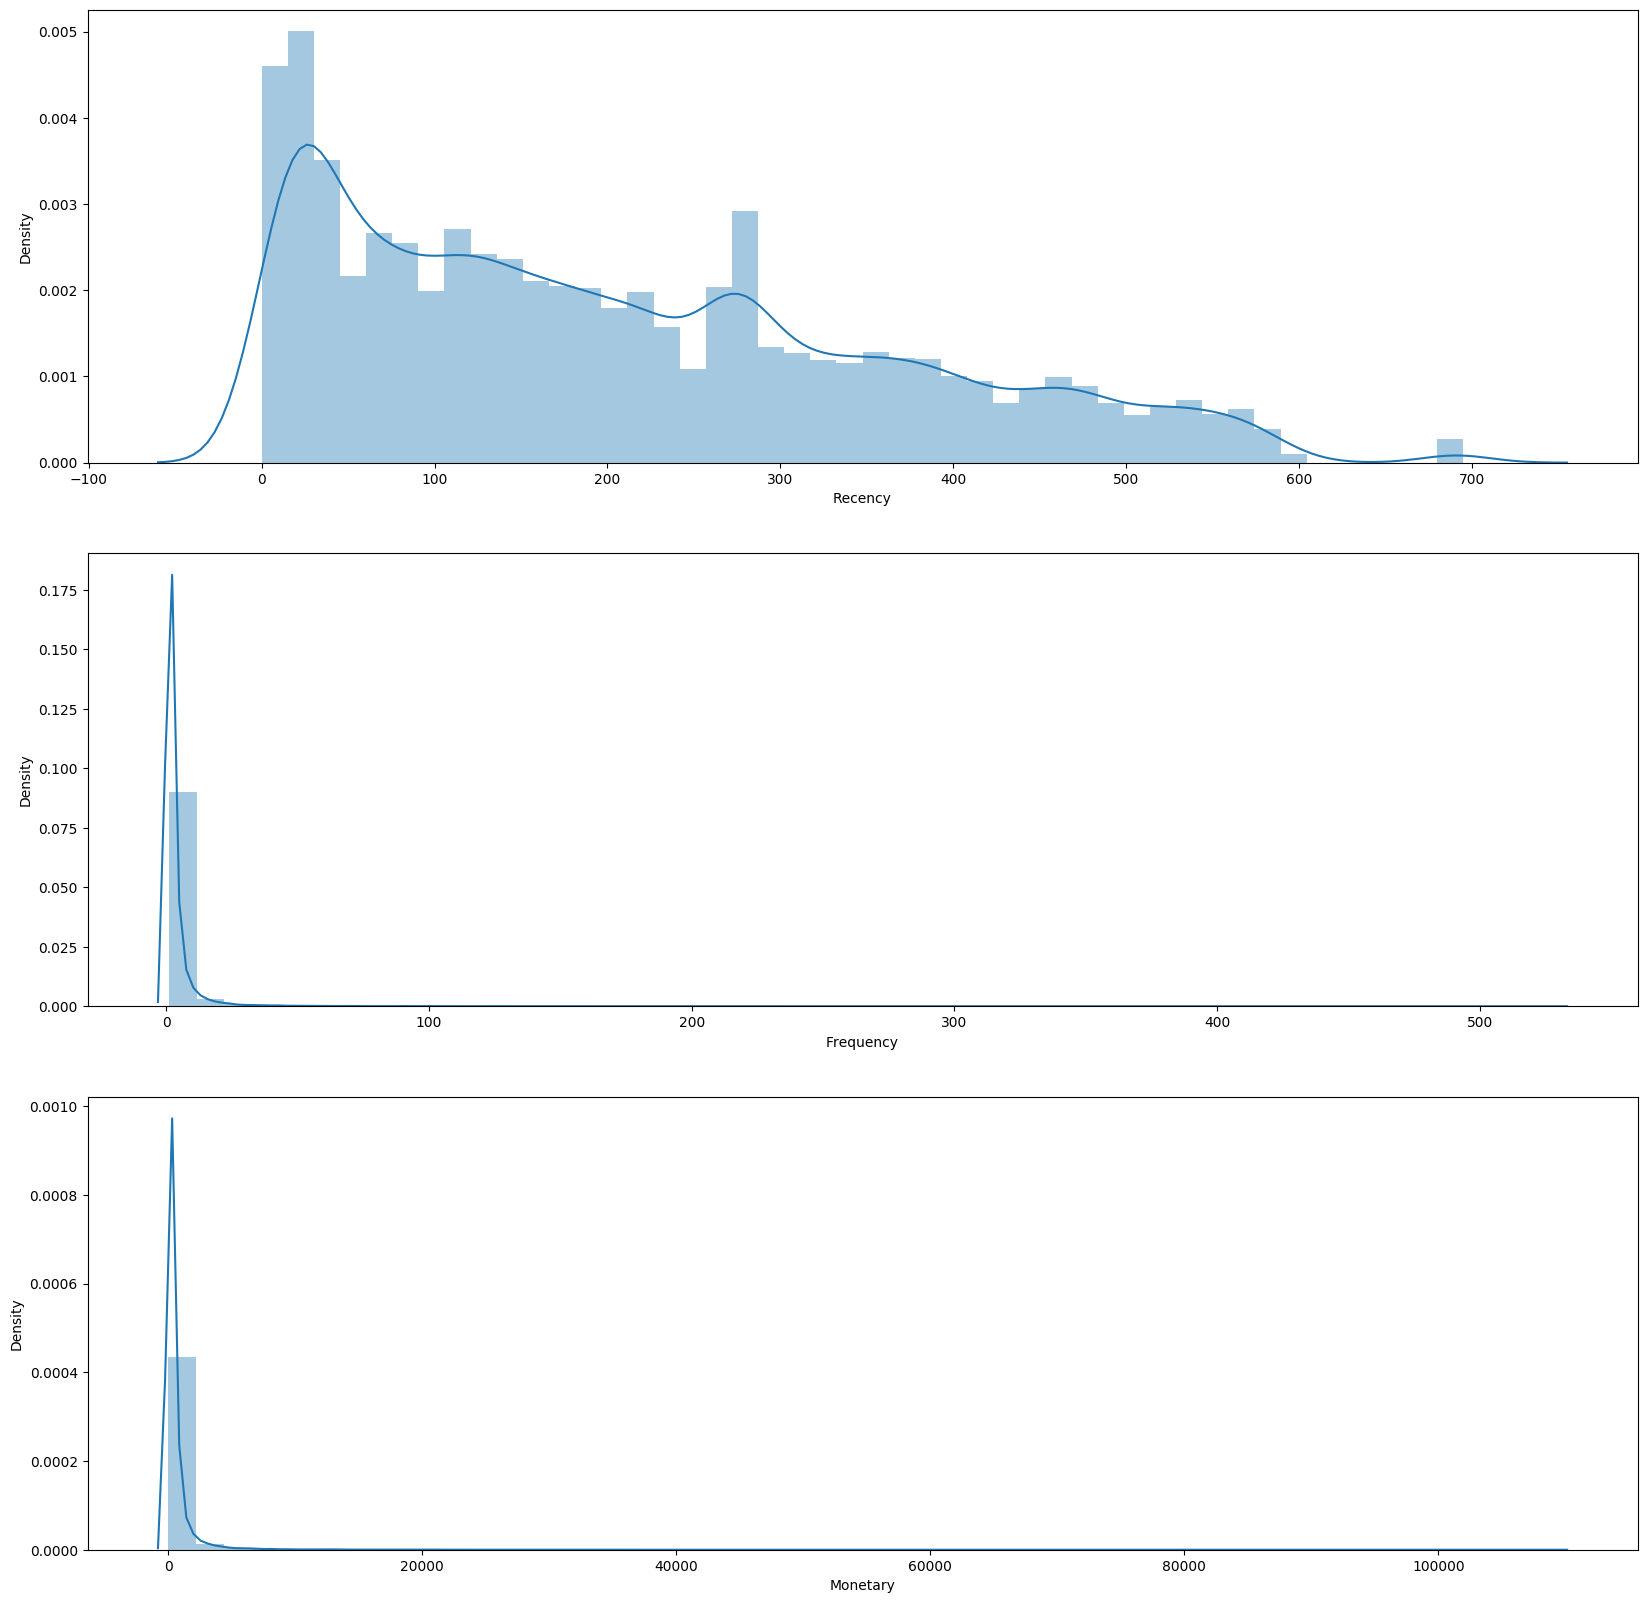

In [77]:
#plot RFM distribution
plt.figure(figsize=(20,20))
#plot distribution of Recency
plt.subplot(3,1,1);
sns.distplot(df_rfm["Recency"])

#plot distribution of Frequency
plt.subplot(3,1,2);
sns.distplot(df_rfm["Frequency"])

#plot distribution of Monetary
plt.subplot(3,1,3);
sns.distplot(df_rfm["Monetary"])
plt.show()

In [78]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(df_rfm)
cluster_labels = kmeans.labels_
data_rfm_k4 = df_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)


Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         209.1       2.5    342.9  30776
1          96.4      68.1  17297.7    144
2          82.8     226.3  58130.6     21
3         134.1      18.2   4322.3   1275

In [79]:
data_melt = pd.melt(
                    data_rfm_k4.reset_index(),               
                    id_vars=['product_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', value_name='Value'
                    )
data_melt.head(10)

,product_id,Cluster,Metric,Value
0,00066f42aeeb9f3007548bb9d3f33c38,0,Recency,100.0
1,00088930e925c41fd95ebfe695fd2655,0,Recency,259.0
2,0009406fd7479715e4bef61dd91f2462,0,Recency,250.0
3,000b8f95fcb9e0096488278317764d19,0,Recency,19.0
4,000d9be29b5207b54e86aa1b1ac54872,0,Recency,148.0
5,0011c512eb256aa0dbbb544d8dffcf6e,0,Recency,257.0
6,00126f27c813603687e6ce486d909d01,0,Recency,345.0
7,001795ec6f1b187d37335e1c4704762e,0,Recency,245.0
8,001b237c0e9bb435f2e54071129237e9,0,Recency,20.0
9,001b72dfd63e9833e8c02742adf472e3,0,Recency,259.0


In [80]:
data_melt['Cluster'].value_counts()

0    92328
3     3825
1      432
2       63
Name: Cluster, dtype: int64

# RFM Quartiles
The simples way to create product segments from RFM model is to use quartiles.We assign score from 1 to 4 to Recency,Frequency and Monetary.4 is the best/heighest value, and 1 is the lowest/worst value. A RFM score is calculated simply by combining individual RFM score numbers.

Product with the lowest recency, highest frequency and monetary amounts considered as top selling products.

In [81]:
quantiles=df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Recency': {0.25: 67.0, 0.5: 174.0, 0.75: 312.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 3.0},
 'Monetary': {0.25: 91.78750000000001, 0.5: 198.26, 0.75: 477.425}}

In [82]:
#x=value, p=recency,frequency, monetary_value,  d=quartiles dict
def RScore(x,p,d):
    if x<=d[p][0.25]:
        return 4
    elif x<= d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

# x=value, p=recency,frequency, monetary_value,  k=quartiles dict
def FMScore(x,p,k):
    if x<=k[p][0.25]:
        return 1
    elif x<=k[p][0.50]:
        return 2
    elif x<=k[p][0.75]:
        return 3
    else:
        return 4

In [83]:
#create RFM segmentation table
rfm_segmentation=df_rfm
rfm_segmentation['R_Quartile']=rfm_segmentation["Recency"].apply(RScore,args=('Recency',quantiles))
rfm_segmentation['F_Quartile']=rfm_segmentation["Frequency"].apply(FMScore,args=('Frequency',quantiles))
rfm_segmentation['M_Quartile']=rfm_segmentation["Monetary"].apply(FMScore,args=('Monetary',quantiles))
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
product_id,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,100,1,120.24,3,1,2
00088930e925c41fd95ebfe695fd2655,259,1,143.83,2,1,2
0009406fd7479715e4bef61dd91f2462,250,1,242.10,2,1,3
000b8f95fcb9e0096488278317764d19,19,2,157.00,4,3,2
000d9be29b5207b54e86aa1b1ac54872,148,1,218.27,3,1,3
...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,360,2,285.39,1,3,3
fff81cc3158d2725c0655ab9ba0f712c,30,1,97.89,4,1,2
fff9553ac224cec9d15d49f5a263411f,326,1,43.85,1,1,1


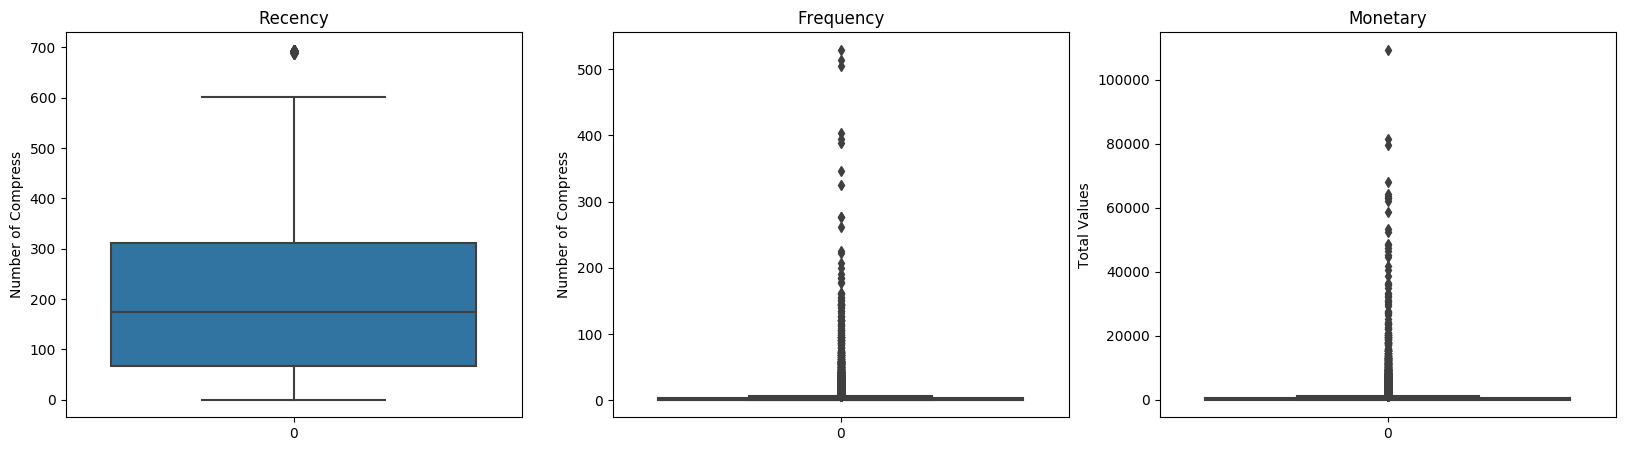

In [84]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(data=df_rfm['Recency'])
plt.title('Recency')
plt.ylabel('Number of Compress')
plt.subplot(1,3,2)
sns.boxplot(data=df_rfm['Frequency'])
plt.title('Frequency')
plt.ylabel('Number of Compress')
plt.subplot(1,3,3)
sns.boxplot(data=df_rfm['Monetary'])
plt.title('Monetary')
plt.ylabel('Total Values')
plt.show()

In [85]:
rfm_segmentation['RFMScore']=rfm_segmentation.R_Quartile.map(str)+rfm_segmentation.F_Quartile.map(str)+rfm_segmentation.M_Quartile.map(str)
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,100,1,120.24,3,1,2,312
00088930e925c41fd95ebfe695fd2655,259,1,143.83,2,1,2,212
0009406fd7479715e4bef61dd91f2462,250,1,242.10,2,1,3,213
000b8f95fcb9e0096488278317764d19,19,2,157.00,4,3,2,432
000d9be29b5207b54e86aa1b1ac54872,148,1,218.27,3,1,3,313
...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,360,2,285.39,1,3,3,133
fff81cc3158d2725c0655ab9ba0f712c,30,1,97.89,4,1,2,412
fff9553ac224cec9d15d49f5a263411f,326,1,43.85,1,1,1,111


- 'Superhit Products': The customer has made frequent and high-value purchases recently, and belongs to one of the top 5 RFM score combinations (444, 443, 433, 442, or 434).
- 'Fast Moving Average Price Products': The customer has made frequent purchases recently, and belongs to one of the RFM score combinations indicating a balance of frequency and monetary value (432, 341, 342, 332, 333, 344, 343, or 441).
- 'Costly Products': The customer has made high-value purchases recently, but not as frequently, and belongs to one of the RFM score combinations indicating a balance of recency and monetary value (334, 234, 214, 224, 413, 314, 244, or 243).
- 'Infrequent Products': The customer has made infrequent purchases and/or lower-value purchases, and belongs to one of the RFM score combinations indicating lower scores in all three dimensions (212, 213, 222, 211, 114, 311, 312, 214, 143, 142, 141, or 241).
- 'Hardly Any Sale Products': The customer has made hardly any purchases and belongs to one of the lowest RFM score combinations (111, 121, 112, 113, or 144).
- 'Average Sale Products': The customer doesn't fit into any of the above categories and is considered to be an average customer in terms of their RFM score.

In [86]:
def segment(x):
    if x in ['444','443','433','442','434']:
        return 'Superhit Products'
    elif x in [ '432','341','342','332','333','344','343','441']:
        return 'Fast Moving Average Price Products '
    elif x in ['334', '234','214','224','413','314','244','243']:
        return 'Costly Products'
    elif x in ['212', '213', '222','211','114','311','312','214','143','142','141','241']:
        return 'Infrequent Products'
    elif x in ['111', '121','112','113','144']:
        return 'Hardly Any Sale Products'
    else:
        return 'Average Sale Products'

In [87]:
rfm_segmentation['segments'] = rfm_segmentation['RFMScore'].apply(segment)
rfm_segmentation['segments'].value_counts()

Average Sale Products                  7850
Infrequent Products                    7602
Hardly Any Sale Products               5398
Fast Moving Average Price Products     3880
Superhit Products                      3804
Costly Products                        3682
Name: segments, dtype: int64

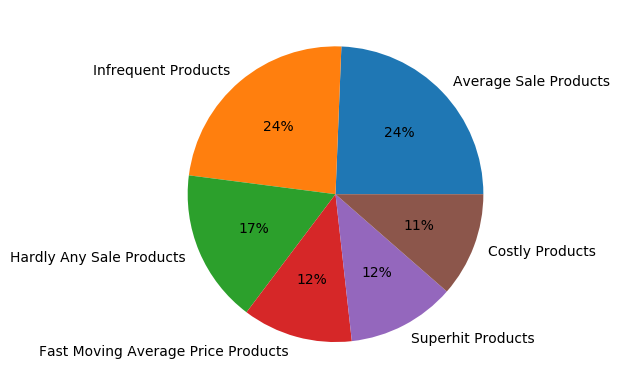

In [88]:
plt.pie(rfm_segmentation['segments'].value_counts(),
        labels=rfm_segmentation['segments'].value_counts().index,
        autopct='%.0f%%')
plt.show()

# Observation
- "Infrequent cheap products" is the largest category at 24%, indicating customers prefer affordable prices even if products are not bought frequently.

- "Average sale" category is also 24%, suggesting that customers are willing to spend money on products offering good value for money.

- "Superhit Products" and "Fast moving average price products" are equally popular and have a share of 12% each.

- "Hardly any sale product" has a share of 17%, indicating that some products are not selling well and may need re-evaluation of product offerings or marketing strategies.

- "Costly product" has a share of 11%, indicating that fewer products are priced higher and may need to be promoted or priced lower to increase sales.

In [89]:
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,segments
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,100,1,120.24,3,1,2,312,Infrequent Products
00088930e925c41fd95ebfe695fd2655,259,1,143.83,2,1,2,212,Infrequent Products
0009406fd7479715e4bef61dd91f2462,250,1,242.10,2,1,3,213,Infrequent Products
000b8f95fcb9e0096488278317764d19,19,2,157.00,4,3,2,432,Fast Moving Average Price Products
000d9be29b5207b54e86aa1b1ac54872,148,1,218.27,3,1,3,313,Average Sale Products
...,...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,360,2,285.39,1,3,3,133,Average Sale Products
fff81cc3158d2725c0655ab9ba0f712c,30,1,97.89,4,1,2,412,Average Sale Products
fff9553ac224cec9d15d49f5a263411f,326,1,43.85,1,1,1,111,Hardly Any Sale Products


In [90]:
Product_cat= rfm_segmentation.merge(products[['product_id','product_category_name']],on='product_id',how='left')


In [91]:
Product_cat = Product_cat.loc[:, ['product_category_name','segments']]
Product_cat

,product_category_name,segments
0,toys,Infrequent Products
1,auto,Infrequent Products
2,toys,Infrequent Products
3,housewares,Fast Moving Average Price Products
4,toys,Average Sale Products
...,...,...
32211,toys,Average Sale Products
32212,health_beauty,Average Sale Products
32213,toys,Hardly Any Sale Products
32214,toys,Superhit Products


In [92]:
pivot = pd.pivot_table(data=Product_cat, index=['product_category_name'], columns=['segments'], aggfunc=len,  fill_value=0)
pivot_sort=pivot.sort_values('Costly Products', ascending=False)
pivot_sort

segments,Average Sale Products,Costly Products,Fast Moving Average Price Products,Hardly Any Sale Products,Infrequent Products,Superhit Products
product_category_name,,,,,,
toys,5838,2769,2962,4087,5749,2784
furniture_decor,154,80,64,161,139,70
bed_bath_table,186,76,117,135,163,104
computers_accessories,94,74,49,52,89,53
sports_leisure,159,71,85,126,189,80
...,...,...,...,...,...,...
food,6,0,4,1,3,6
fashion_sport,1,0,0,2,0,0
fashion_childrens_clothes,0,0,1,0,0,0


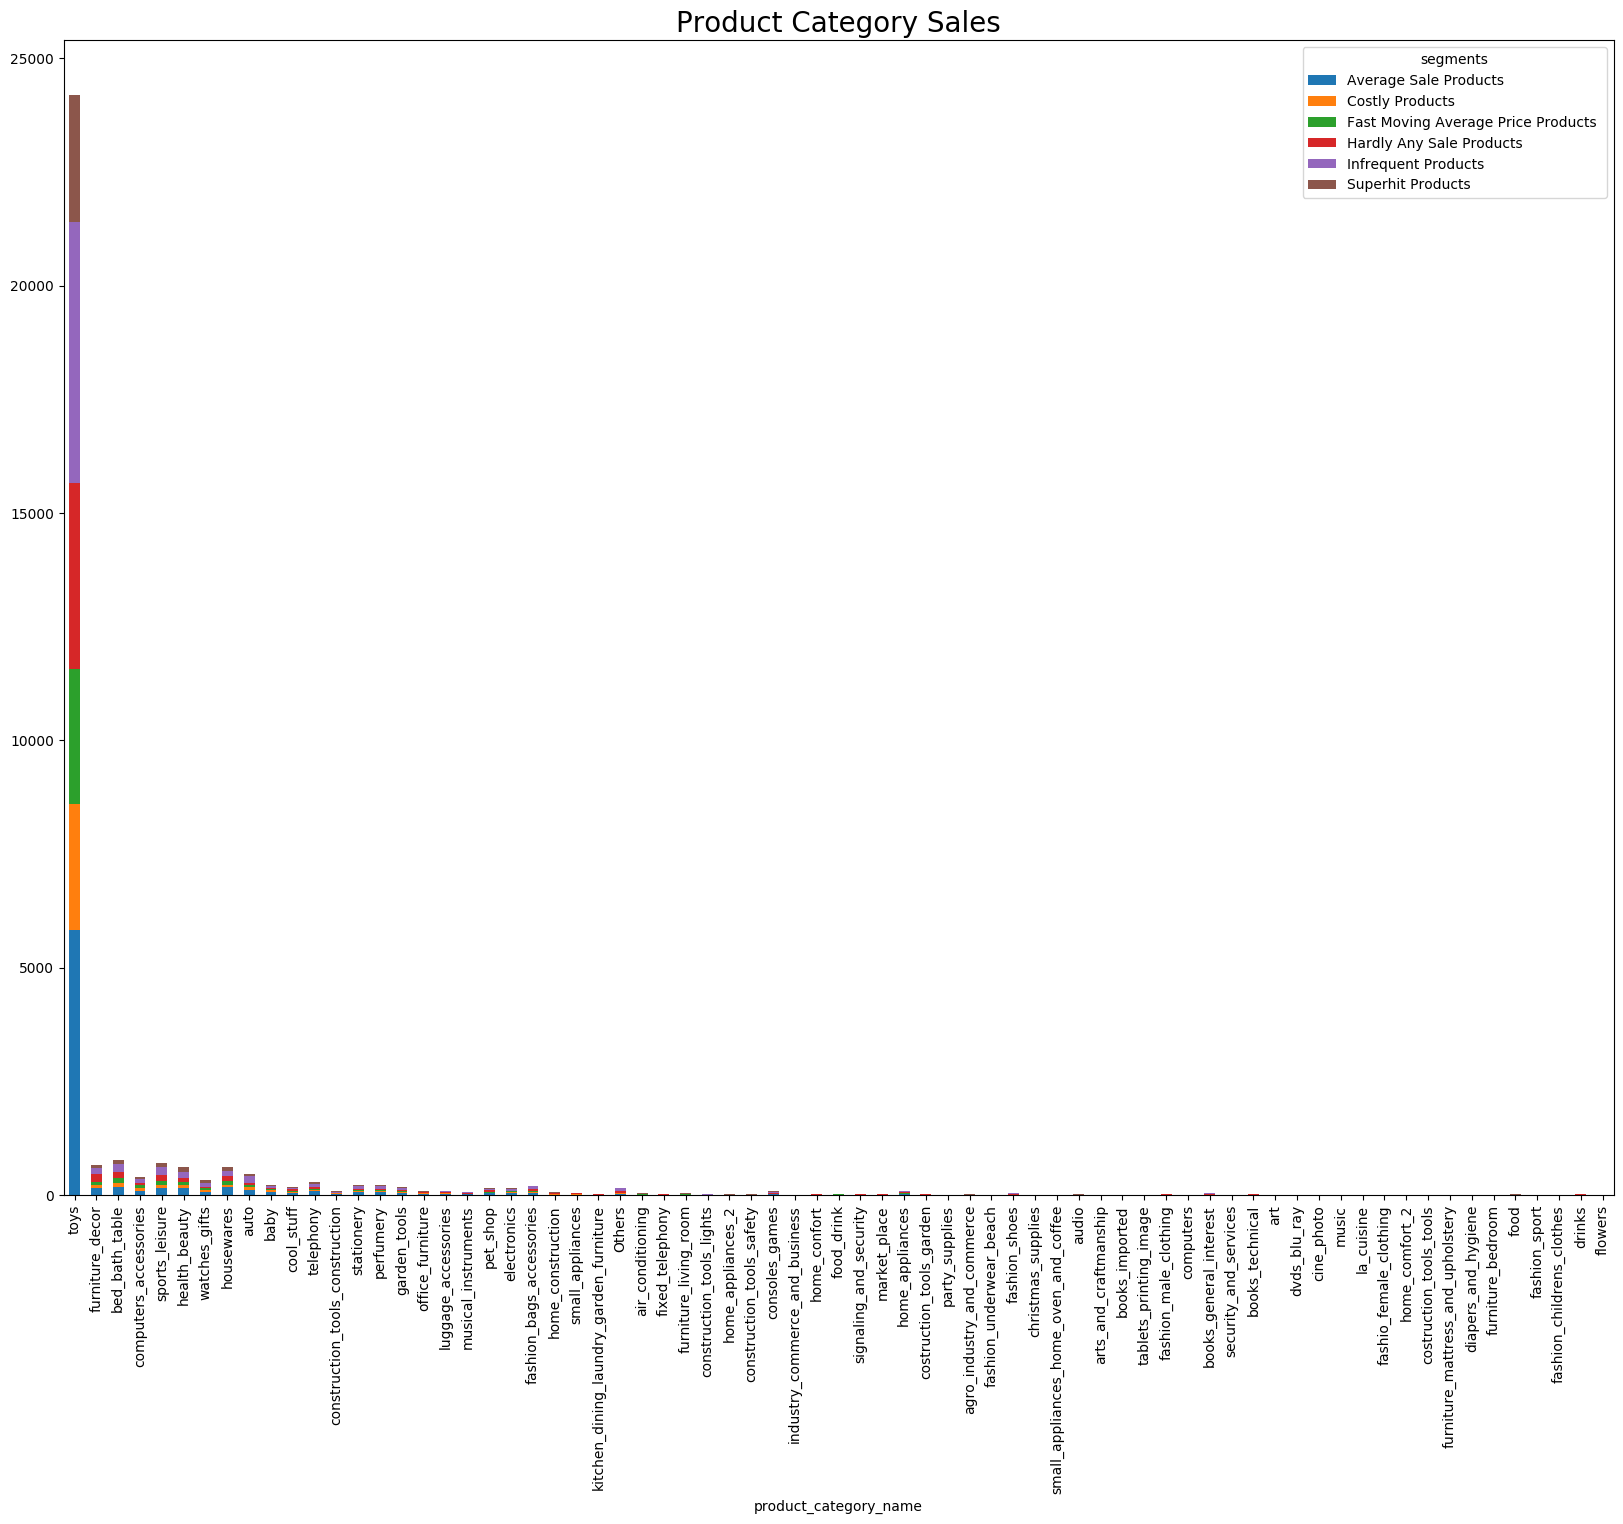

In [93]:
ax = pivot_sort.plot.bar(stacked=True, figsize=(20,15))
ax.set_title('Product Category Sales', fontsize=20)
plt.show()

In [94]:
toys=pivot_sort.loc['toys']
toys=pd.DataFrame(toys)
toys

,toys
segments,
Average Sale Products,5838
Costly Products,2769
Fast Moving Average Price Products,2962
Hardly Any Sale Products,4087
Infrequent Products,5749
Superhit Products,2784


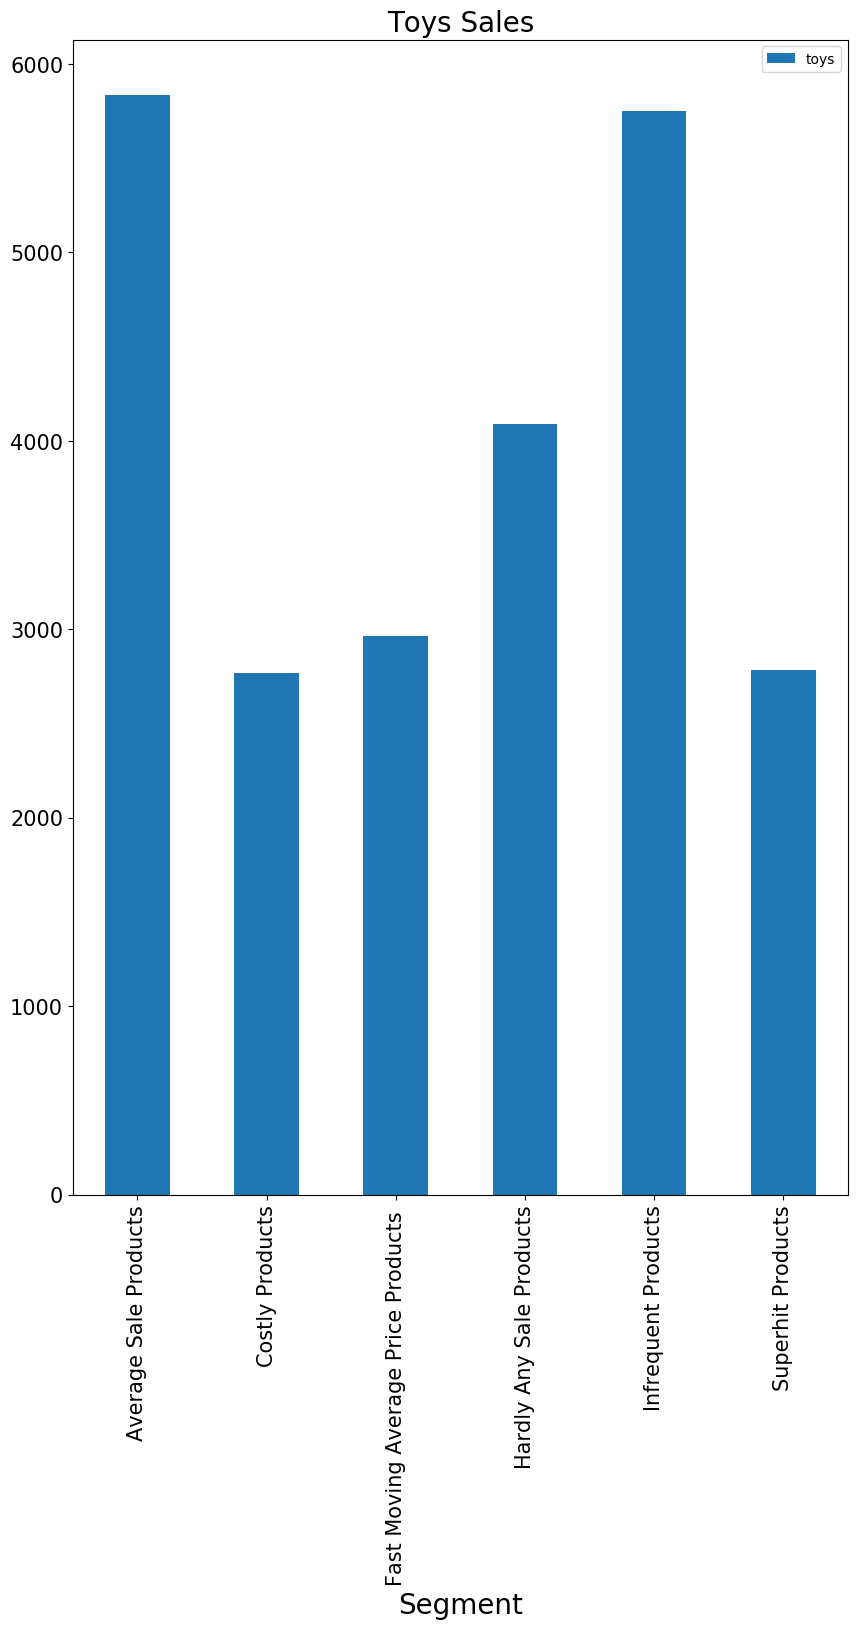

In [95]:
ax = toys.plot.bar(stacked=False, figsize=(10,15))
ax.set_title('Toys Sales', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Segment',fontsize=20)
plt.show()

# Observation:
- The "infrequent products" segment has the highest number of products in the Toys category, indicating a larger variety of products that are sold less frequently.

- The "average sale product" segment is the second-highest, suggesting a significant number of products with moderate sales.

- The "superhit products" segment has the least number of products, indicating fewer products that are particularly popular. There may be opportunities to increase sales in this segment through effective promotion or pricing adjustments. Meanwhile, unprofitable products in the "infrequent products" segment should be considered for reduction.

In [96]:
drop_toys=pivot_sort.drop(['toys'])
drop_toys

segments,Average Sale Products,Costly Products,Fast Moving Average Price Products,Hardly Any Sale Products,Infrequent Products,Superhit Products
product_category_name,,,,,,
furniture_decor,154,80,64,161,139,70
bed_bath_table,186,76,117,135,163,104
computers_accessories,94,74,49,52,89,53
sports_leisure,159,71,85,126,189,80
health_beauty,158,60,72,85,138,117
...,...,...,...,...,...,...
food,6,0,4,1,3,6
fashion_sport,1,0,0,2,0,0
fashion_childrens_clothes,0,0,1,0,0,0


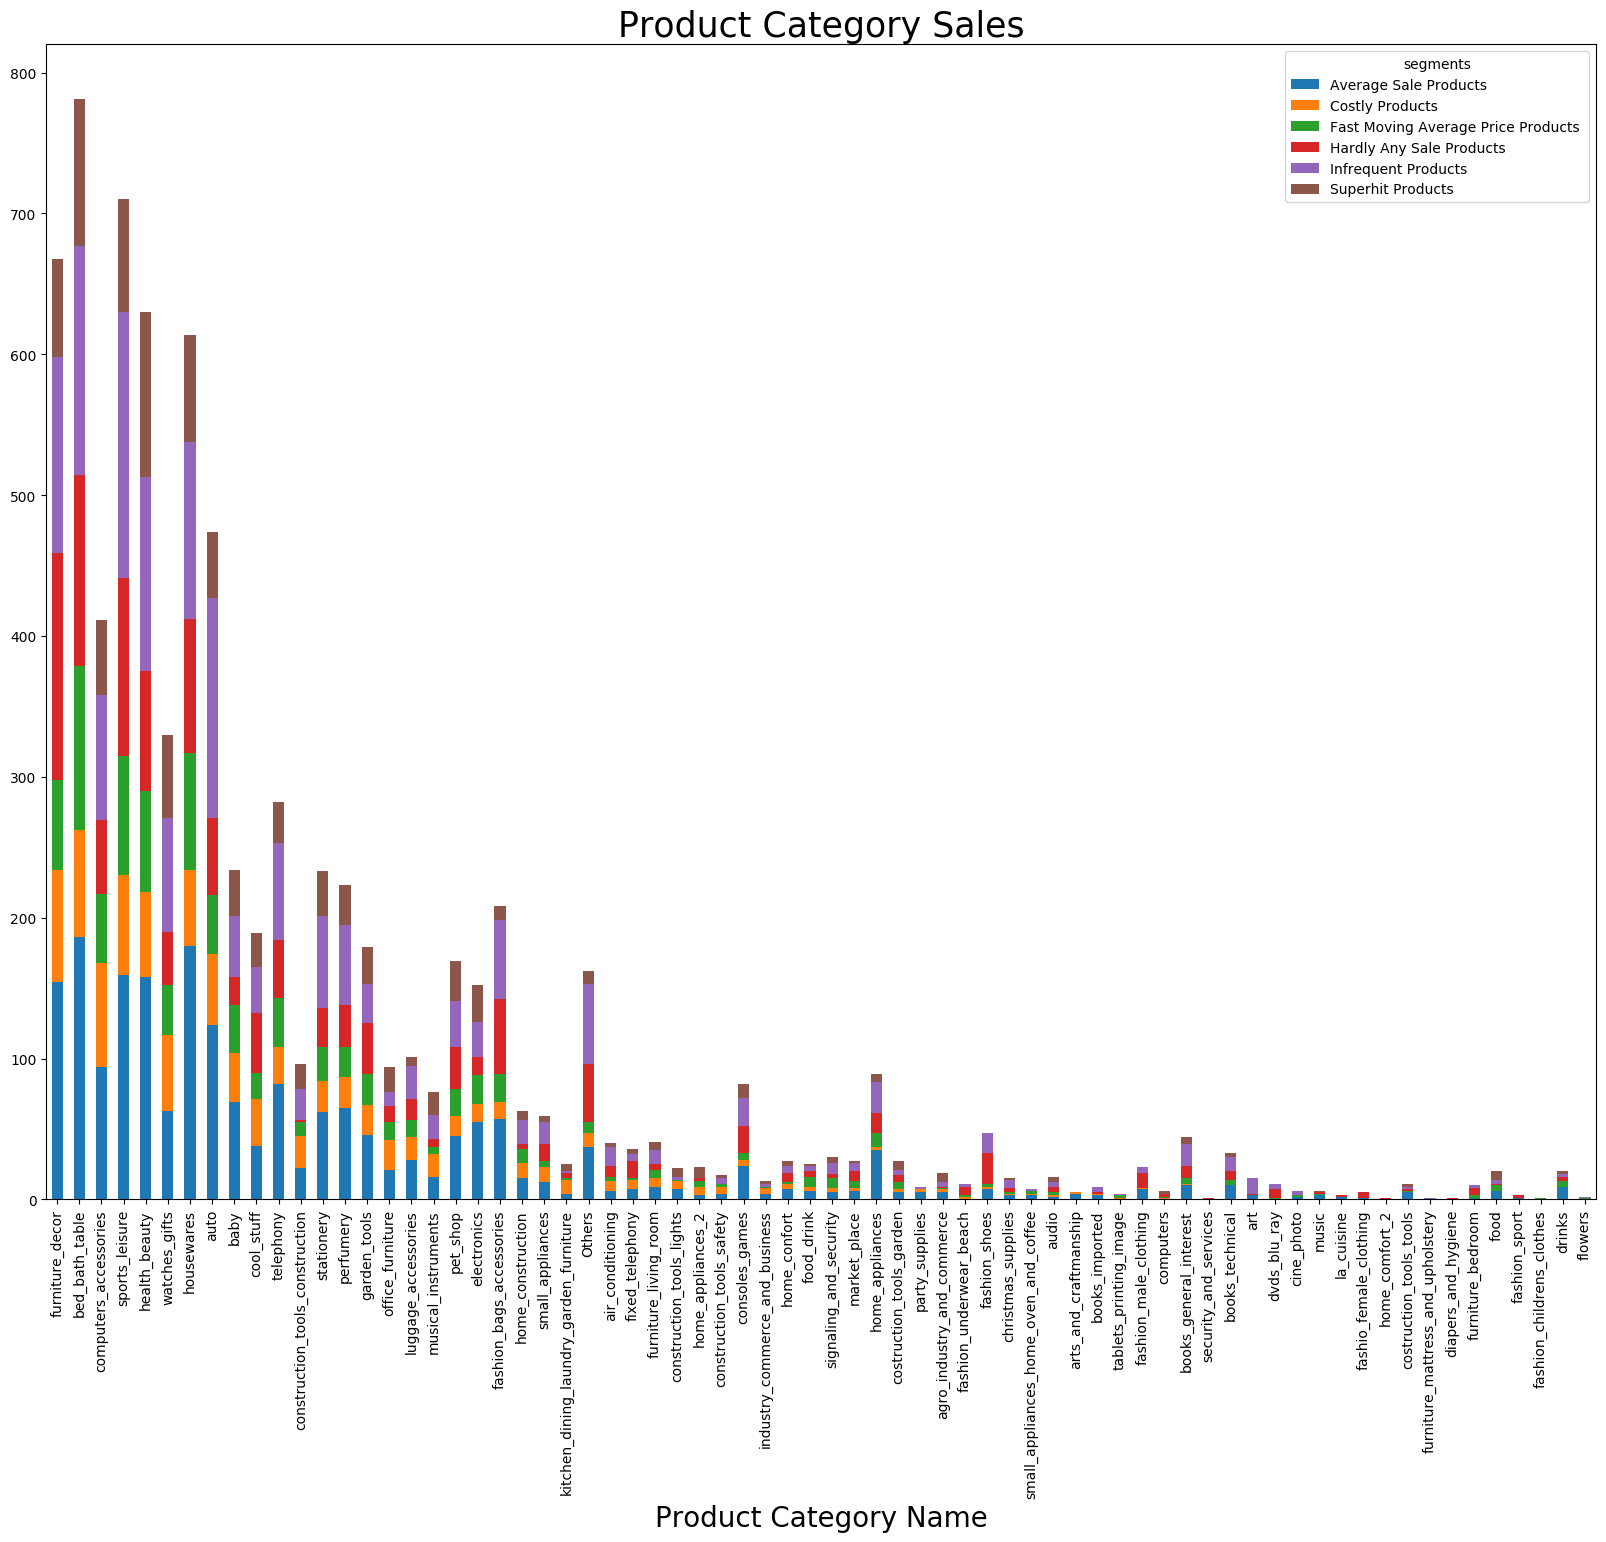

In [97]:
ax = drop_toys.plot.bar(stacked=True, figsize=(20,15))
ax.set_title('Product Category Sales', fontsize=25)
plt.xlabel('Product Category Name',fontsize=20)
plt.show()

# Observation
- The "average sale product" and "infrequent product" segments have the highest number of products in each category.

- The "fast-moving average price product," "costly product," and "super hit product" segments have the least number of products in each category.

- There is also a high number of products in the "hardly any sale product" segment.


# Market Basket Analysis

In [98]:
MBA = order_items.merge(products[['product_id','product_category_name']], on='product_id', how='inner')
MBA.shape

(112650, 7)

In [99]:
MBA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               112650 non-null  object 
 1   order_item_id          112650 non-null  int64  
 2   product_id             112650 non-null  object 
 3   seller_id              112650 non-null  object 
 4   price                  112650 non-null  float64
 5   shipping_charges       112650 non-null  float64
 6   product_category_name  112650 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 6.9+ MB


In [100]:
# Creating a basket for the analysis 
Basket = (data.groupby(['order_id', 'product_category_name'])
          ['order_item_id'].sum().unstack().reset_index().fillna(0).set_index('order_id'))

In [101]:
Basket

product_category_name,Others,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00018f77f2f0320c557190d7a144bdd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
000229ec398224ef6ca0657da4fc703e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00024acbcdf0a6daa1e931b038114c75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00042b26cf59d7ce69dfabb4e55b4fd9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fffcd46ef2263f404302a634eb57f7eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
fffce4705a9662cd70adb13d4a31832d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [102]:
# Converting the values to 0 or 1

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

Basket_encode = Basket.applymap(encode_units)
Basket_encode

product_category_name,Others,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00018f77f2f0320c557190d7a144bdd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
000229ec398224ef6ca0657da4fc703e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00024acbcdf0a6daa1e931b038114c75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00042b26cf59d7ce69dfabb4e55b4fd9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fffcd46ef2263f404302a634eb57f7eb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
fffce4705a9662cd70adb13d4a31832d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [103]:
# Filter the Basket with the sum of values having >=2
#  Bought More Than 1 Items Only

Basket_encode_filter = Basket_encode[(Basket_encode > 0).sum(axis=1) >=2]
Basket_encode_filter

product_category_name,Others,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00337fe25a3780b3424d9ad7c5a4b35e,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
00946f674d880be1f188abc10ad7cf46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00bcee890eba57a9767c7b5ca12d3a1b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
01144cadcf64b6427f0a6580a3033220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
013a98b3a668bcef05b98898177f6923,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff632bc583a94f23c59db4cbaa0ba2ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ffa466d3e55f98477b7e0da764df3c6c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ffb9a9cd00c74c11c24aa30b3d78e03b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [104]:
 !pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
# Importing libraries for performing Market Basket Analysis.

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [106]:
frequent_itemsets = apriori(Basket_encode_filter, min_support=0.03, 
                            use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
frequent_itemsets["Length"] = frequent_itemsets['itemsets'].apply(lambda x:len(x))

frequent_itemsets

,support,itemsets,Length
0,0.969231,(toys),1
1,0.227692,(bed_bath_table),1
2,0.223846,"(toys, bed_bath_table)",2
3,0.125385,(furniture_decor),1
4,0.117692,"(toys, furniture_decor)",2
5,0.083077,(computers_accessories),1
6,0.079231,"(toys, computers_accessories)",2
7,0.065385,(health_beauty),1
8,0.061538,"(toys, health_beauty)",2
9,0.057692,(watches_gifts),1


In [107]:
rules = association_rules(frequent_itemsets, metric='lift', 
                          min_threshold = 0.9).sort_values('lift', ascending=False).reset_index(drop=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(toys),(bed_bath_table),0.969231,0.227692,0.223846,0.230952,1.014318,0.003160,1.004239
1,(bed_bath_table),(toys),0.227692,0.969231,0.223846,0.983108,1.014318,0.003160,1.821538
2,(toys),(fashion_bags_accessories),0.969231,0.032308,0.031538,0.032540,1.007181,0.000225,1.000240
3,(fashion_bags_accessories),(toys),0.032308,0.969231,0.031538,0.976190,1.007181,0.000225,1.292308
4,(toys),(auto),0.969231,0.030769,0.030000,0.030952,1.005952,0.000178,1.000189
5,(auto),(toys),0.030769,0.969231,0.030000,0.975000,1.005952,0.000178,1.230769
6,(watches_gifts),(toys),0.057692,0.969231,0.056154,0.973333,1.004233,0.000237,1.153846
7,(toys),(watches_gifts),0.969231,0.057692,0.056154,0.057937,1.004233,0.000237,1.000259
8,(toys),(computers_accessories),0.969231,0.083077,0.079231,0.081746,0.983980,-0.001290,0.998551
9,(computers_accessories),(toys),0.083077,0.969231,0.079231,0.953704,0.983980,-0.001290,0.664615


# Oberservation
- 97% of customers buying toys are likely to buy bed_bath_table
- 97% of customers buying toys are likely to buy furniture_decor
- 97% of customers buying toys are likely to buy computers_accessories

Top five products categories in groups of twos are:

- Toys and Bed Bath Table
- Toys and Furniture Decor
- Toys and Computers Accessories
- Toys and Watches Gift
- Toys and Health & Beauty

In [108]:
# Filter the Basket with the sum of values having >=3

Basket_encode_filter_1 = Basket_encode[(Basket_encode > 0).sum(axis=1) >=3]
Basket_encode_filter_1

product_category_name,Others,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
0a77b770428bccbea7f9dbf8aec5d6ae,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1c4a92d82c1b0dec18bef12da3fa7756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
43443d5fff4b94d98df1ad41af13d302,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5337d26d14027f547caacb7fee230f81,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
91be51c856a90d7efe86cf9d082d6ae3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
a98012aa8c697f2bcff9f8c2183e0f2b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
c6a7876557e3e3e31f229852dfa4f5c3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
d4bec1a24c97bd17be18d77297a0f6a0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ddb33b0aa1ca6227208f0ca0564f0696,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [109]:
frequent_itemsets_1 = apriori(Basket_encode_filter_1, min_support=0.03, 
                            use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
frequent_itemsets_1["Length"] = frequent_itemsets_1['itemsets'].apply(lambda x:len(x))

frequent_itemsets_1

,support,itemsets,Length
0,1.0,(toys),1
1,0.5,(bed_bath_table),1
2,0.5,"(toys, bed_bath_table)",2
3,0.4,(furniture_decor),1
4,0.4,"(toys, furniture_decor)",2
5,0.2,(garden_tools),1
6,0.2,(computers_accessories),1
7,0.2,"(toys, garden_tools)",2
8,0.2,"(toys, computers_accessories)",2
9,0.2,"(toys, furniture_decor, bed_bath_table)",3


Choosing the lift with the highest value to determine the best basket of three product

In [110]:
rules_1 = association_rules(frequent_itemsets_1, metric='lift', 
                          min_threshold = 1).sort_values('lift', ascending=False).reset_index(drop=True)
rules_1.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(toys, telephony)",(cine_photo),0.1,0.1,0.1,1.00,10.0,0.09,inf
1,(telephony),(cine_photo),0.1,0.1,0.1,1.00,10.0,0.09,inf
2,(cine_photo),"(toys, telephony)",0.1,0.1,0.1,1.00,10.0,0.09,inf
3,(telephony),"(toys, cine_photo)",0.1,0.1,0.1,1.00,10.0,0.09,inf
4,"(toys, cine_photo)",(telephony),0.1,0.1,0.1,1.00,10.0,0.09,inf
5,(cine_photo),(telephony),0.1,0.1,0.1,1.00,10.0,0.09,inf
6,(computers_accessories),(home_construction),0.2,0.1,0.1,0.50,5.0,0.08,1.8
7,(home_construction),"(toys, computers_accessories)",0.1,0.2,0.1,1.00,5.0,0.08,inf
8,"(toys, computers_accessories)",(home_construction),0.2,0.1,0.1,0.50,5.0,0.08,1.8
9,"(home_construction, toys)",(computers_accessories),0.1,0.2,0.1,1.00,5.0,0.08,inf


# Observations:
#### Top five products categories in groups of threes are:

- Toys, Cine photos and Telephony
- Toys, Home Construction and Computer Accessories
- Toys, Garden Tools and Computer Accessories
- Toys Furniture Decor and Electronics
- Toys, Furniture Decor and Health and Beauty